# `nb06b`: MCMC

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

# Metropolis-Hastings

In [2]:
def mh_sample(theta0, n, log_target, q, seed=0):
    np.random.seed(seed)
    
    theta_t = theta0
    thetas = []
    accepts = 0
    
    for i in tqdm.tqdm(range(n)):
        theta_prop = q(theta_t)
        u = np.random.rand()
        
        if np.log(u) < log_target(theta_prop) - log_target(theta_t):  # since q is symmetric
            theta_t = theta_prop
            accepts += 1
        
        thetas.append(theta_t)
        
    return np.array(thetas), accepts / n

In [9]:
thetas, accept_ratio = mh_sample(0.0, 100000, 
                                 lambda theta: -np.abs(theta), 
                                 #lambda theta: -((theta - 3) ** 2) / (0.5 ** 2), 
                                 lambda theta_t: theta_t + np.random.randn())

print("Accept ratio =", accept_ratio)

100%|██████████| 100000/100000 [00:00<00:00, 183504.60it/s]

Accept ratio = 0.69941


In [10]:
thetas

array([ 0.        ,  0.40015721,  0.40015721, ..., -0.09159888,
       -0.30255561, -0.30255561])

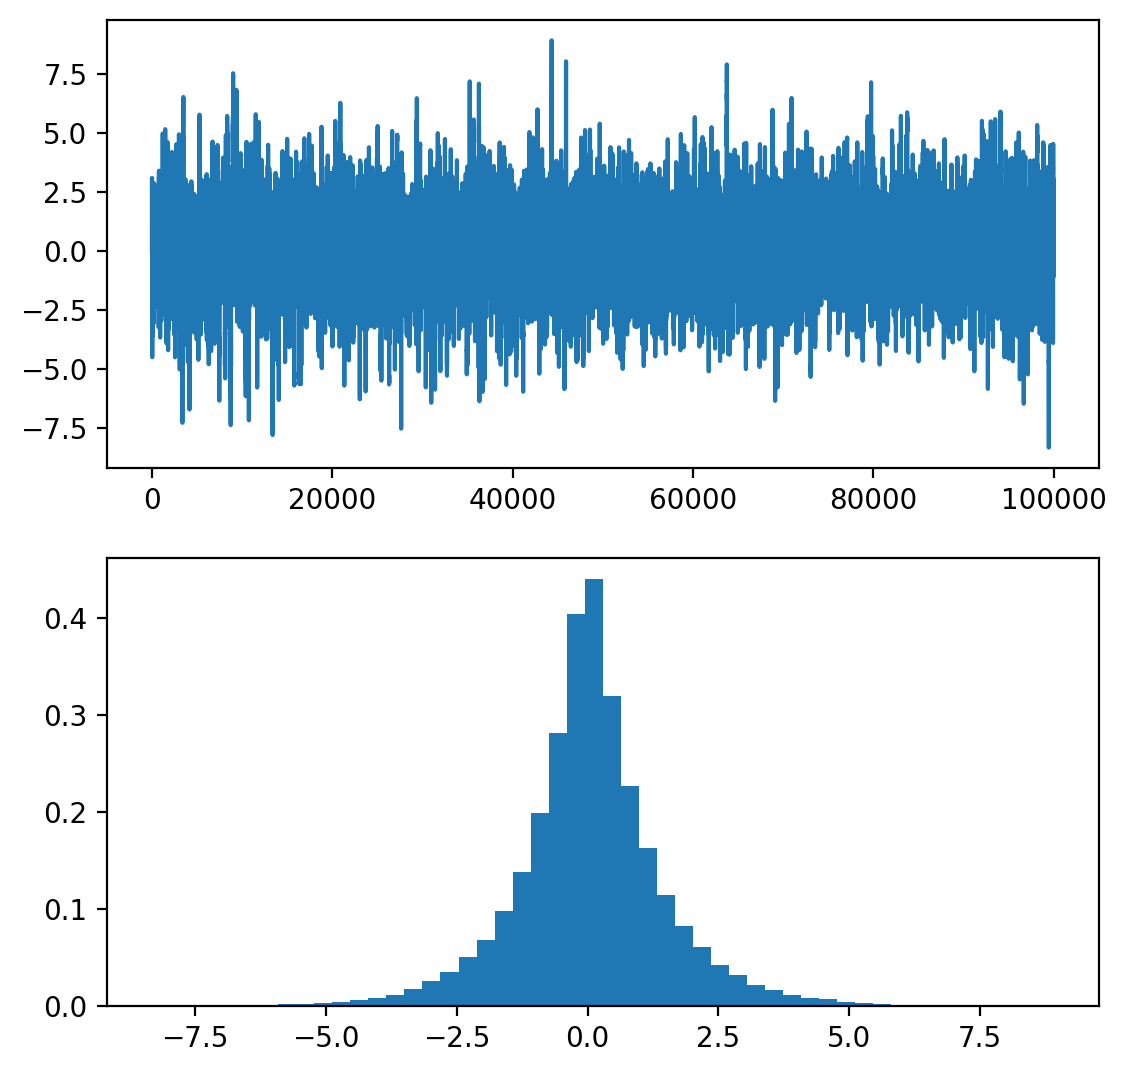

In [ ]:
fig, ax = plt.subplots(2, figsize=(6.4, 6.4), dpi=200)

ax[0].plot(thetas)
ax[1].hist(thetas,lambda theta_t: theta_t + 0.1 * np.random.randn()) bins=50, density=True)

plt.show()

## Proposals

100%|██████████| 10000/10000 [00:00<00:00, 171877.98it/s]


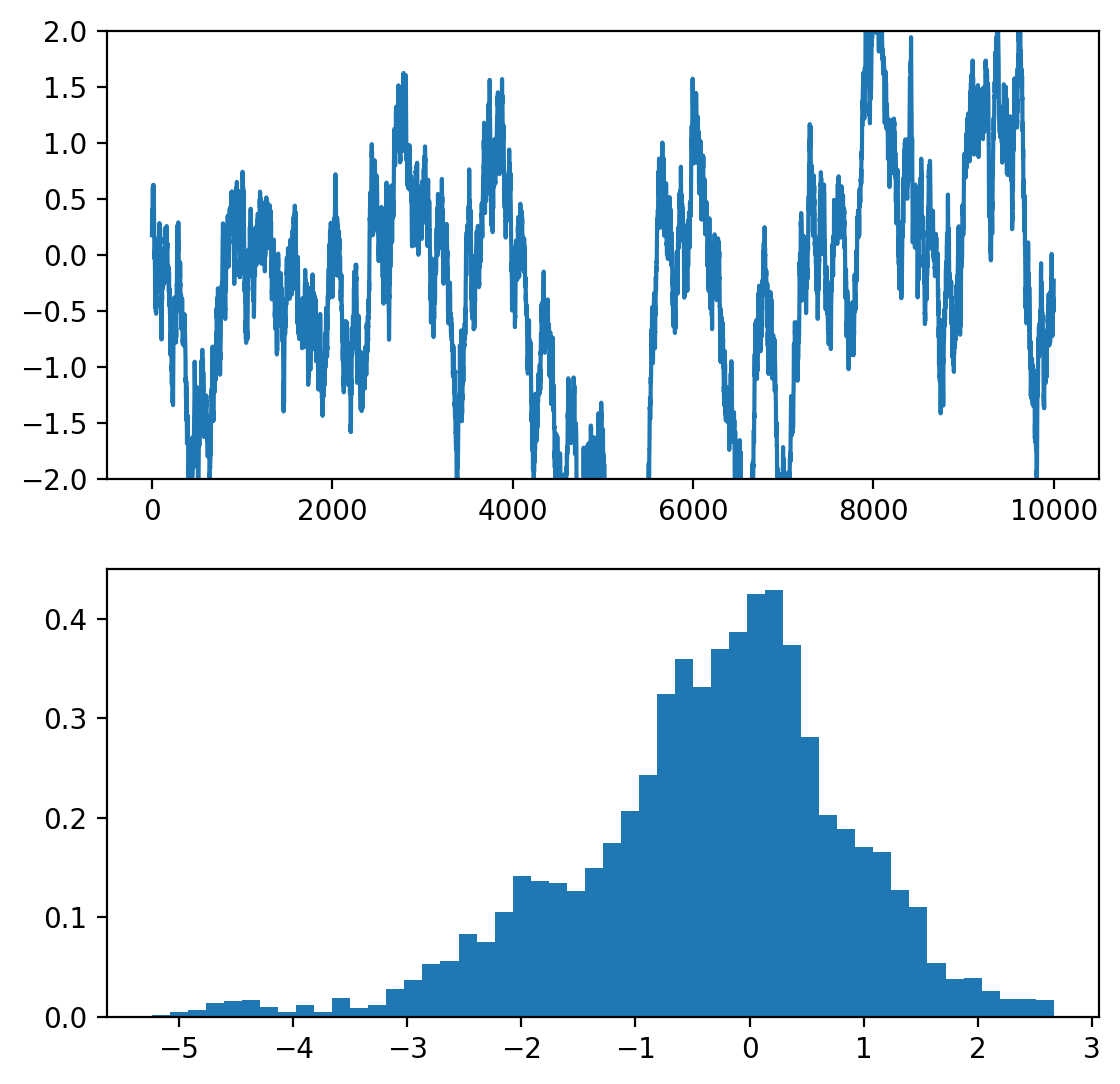

Accept ratio = 0.9633


In [12]:
# Narrow proposal
thetas, accept_ratio = mh_sample(0.0, 10000, 
                                 lambda theta: -np.abs(theta),
                                 lambda theta_t: theta_t + 0.1 * np.random.randn())

fig, ax = plt.subplots(2, figsize=(6.4, 6.4), dpi=200)

ax[0].plot(thetas)
ax[0].set(ylim=(-2, 2))
ax[1].hist(thetas, bins=50, density=True)

plt.show()

print("Accept ratio =", accept_ratio)

100%|██████████| 10000/10000 [00:00<00:00, 179642.20it/s]


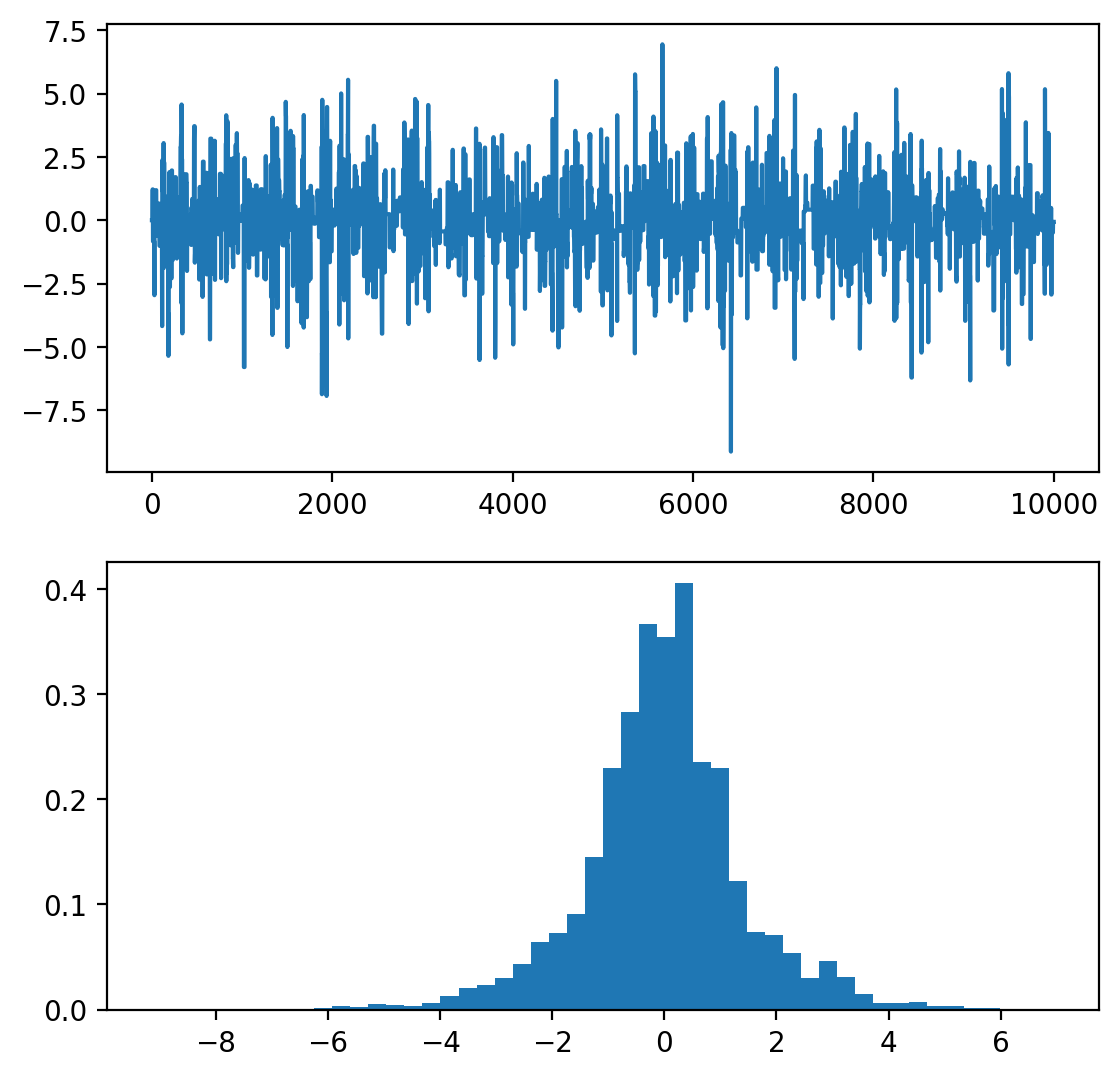

Accept ratio = 0.165


In [13]:
# Wide proposal
thetas, accept_ratio = mh_sample(0.0, 10000, 
                                 lambda theta: -np.abs(theta),
                                 lambda theta_t: theta_t + 10.0 * np.random.randn())

fig, ax = plt.subplots(2, figsize=(6.4, 6.4), dpi=200)

ax[0].plot(thetas)
ax[1].hist(thetas, bins=50, density=True)

plt.show()

print("Accept ratio =", accept_ratio)

In summary:
- Too narrow proposals lead to very high acceptance rates but persistent random walks that can seriously bias the sample. 
- Too wide proposals lead to very low acceptance rates and long sequences of identical states that can be seen as spikes in the histogram of the samples.

## Thining, Warm up

100%|██████████| 500000/500000 [00:02<00:00, 242770.69it/s]


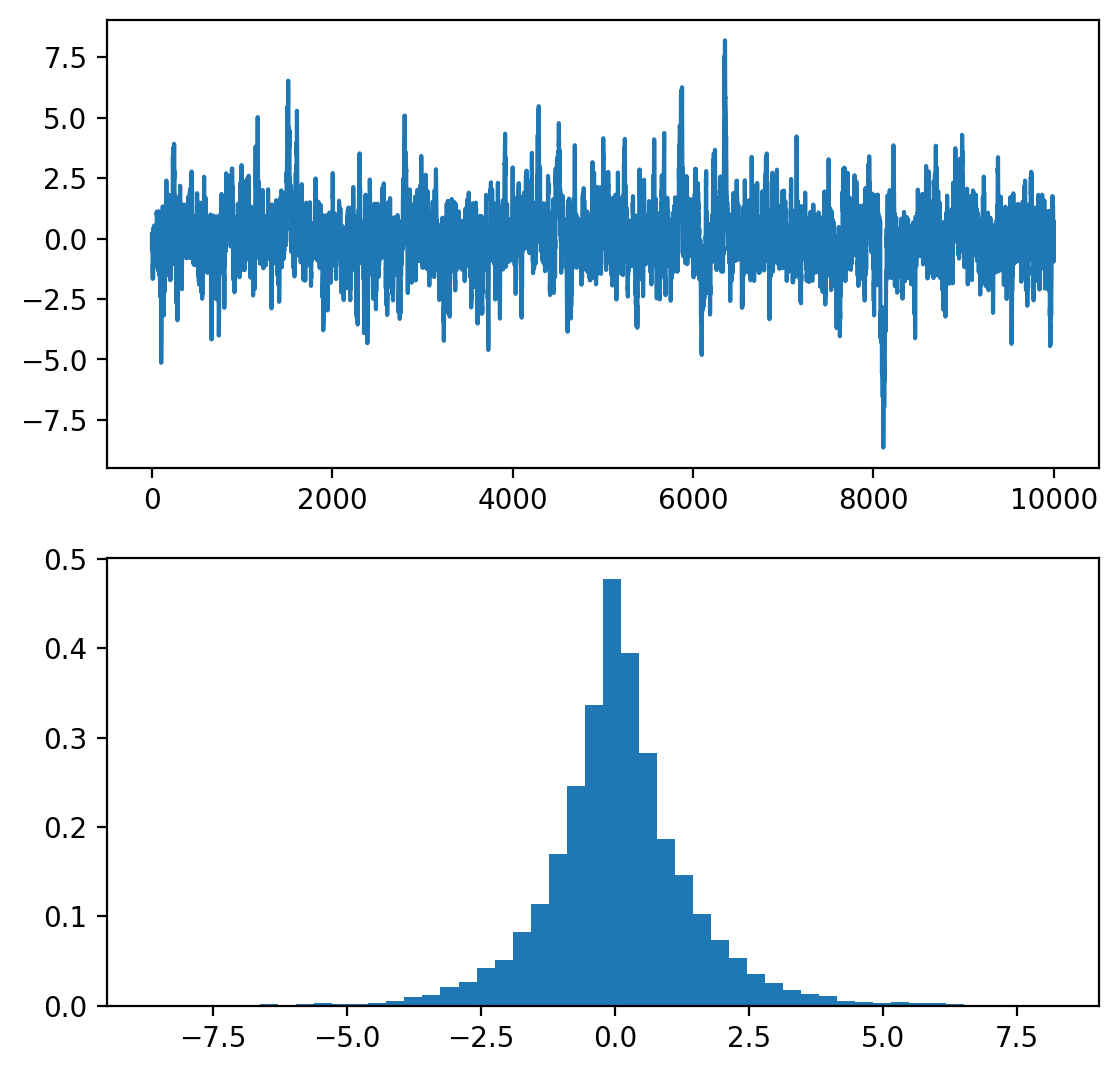

Accept ratio = 0.960988


In [16]:
# Thinning
thetas, accept_ratio = mh_sample(0.0, 10000*50,
                                 lambda theta: -np.abs(theta),
                                 lambda theta_t: theta_t + 0.1 * np.random.randn())

fig, ax = plt.subplots(2, figsize=(6.4, 6.4), dpi=200)

ax[0].plot(thetas[::50])  # keep 1/50 of the samples
ax[1].hist(thetas[::50], bins=50, density=True)

plt.show()

print("Accept ratio =", accept_ratio)

100%|██████████| 10000/10000 [00:00<00:00, 179749.21it/s]


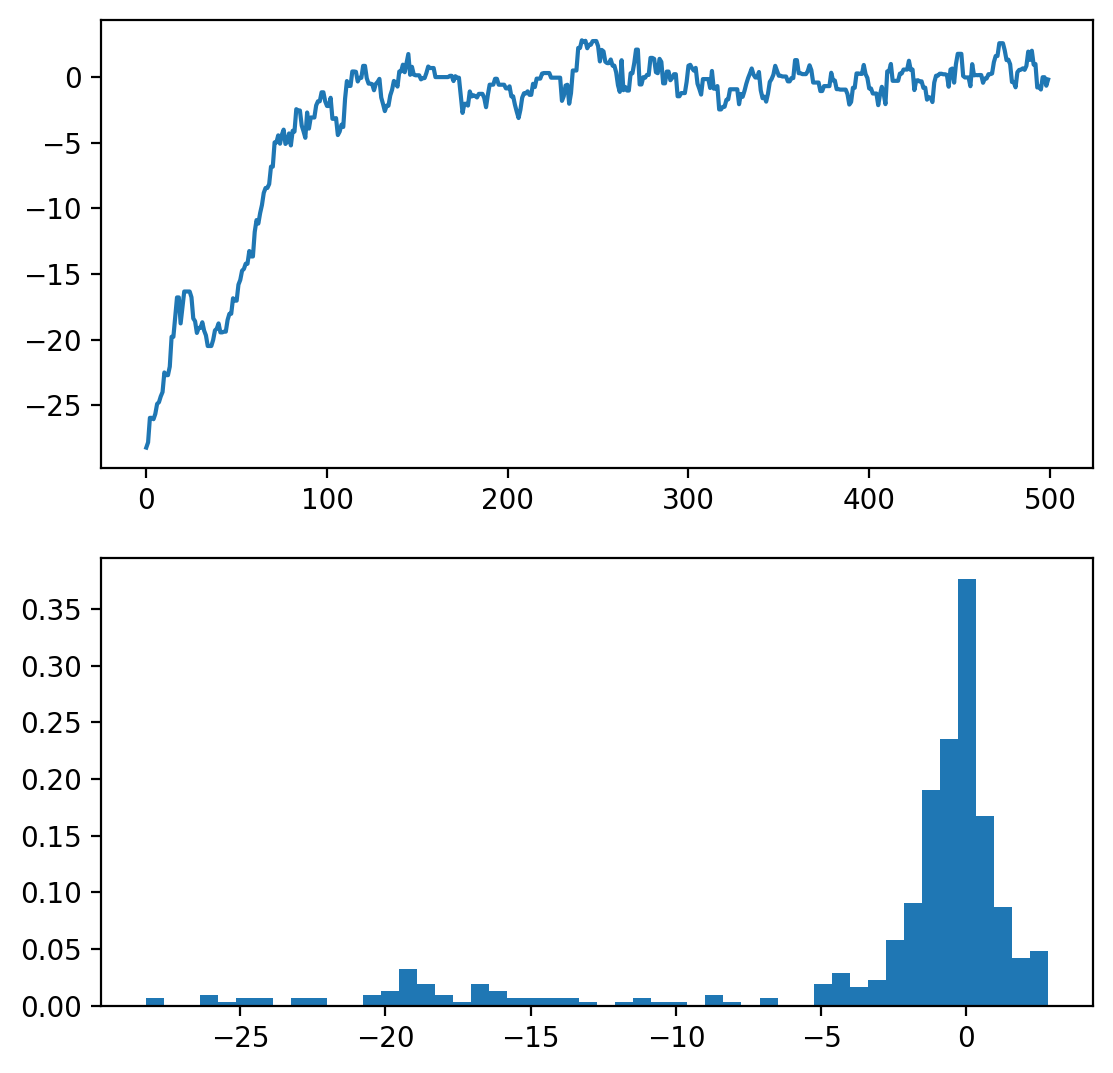

Accept ratio = 0.7082


In [17]:
# Warm up
thetas, accept_ratio = mh_sample(-30.0, 10000,
                                 lambda theta: -np.abs(theta),
                                 lambda theta_t: theta_t + np.random.randn())

fig, ax = plt.subplots(2, figsize=(6.4, 6.4), dpi=200)

ax[0].plot(thetas[:500])  
ax[1].hist(thetas[:500], bins=50, density=True)

plt.show()

print("Accept ratio =", accept_ratio)

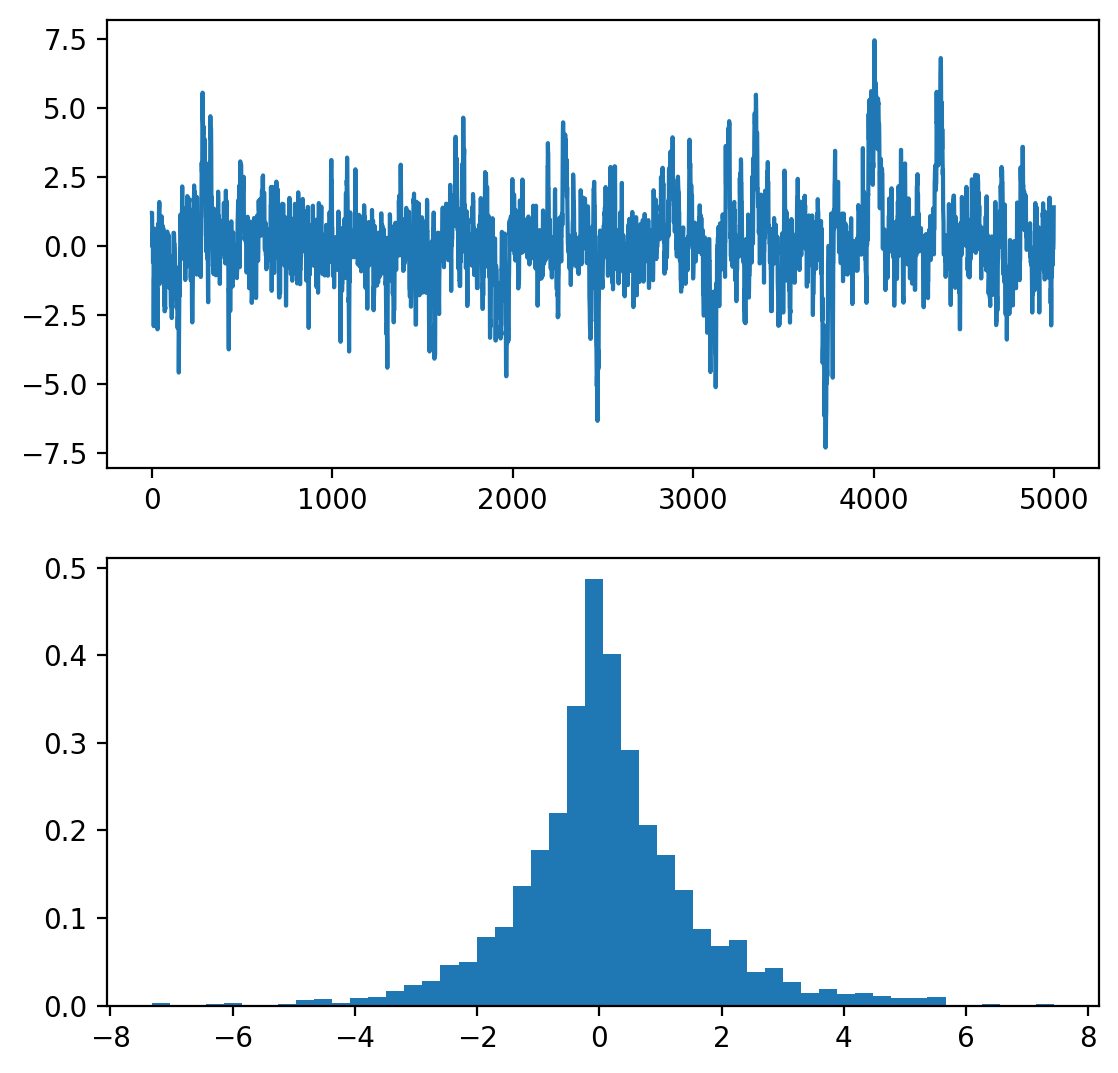

In [18]:
fig, ax = plt.subplots(2, figsize=(6.4, 6.4), dpi=200)

ax[0].plot(thetas[len(thetas)//2:])   # discard the first half
ax[1].hist(thetas[len(thetas)//2:], bins=50, density=True)

plt.show()

# Bayesian inference with MCMC

In [21]:
# Generative model
theta_true = np.array([-3.0, 0.0, np.log(5.0)])

def generate(n_samples, theta_true):
    x = np.random.rand(n_samples) * 20 - 10
    x = np.sort(x)

    w = theta_true[0:2]
    s = np.exp(theta_true[2])

    y = w[0] * x + w[1] + np.random.randn(n_samples) * s

    return x, y

In [22]:
np.random.seed(777)
x, y = generate(10, theta_true)
# y[-1] = y[-1] + 100  # add an outlier

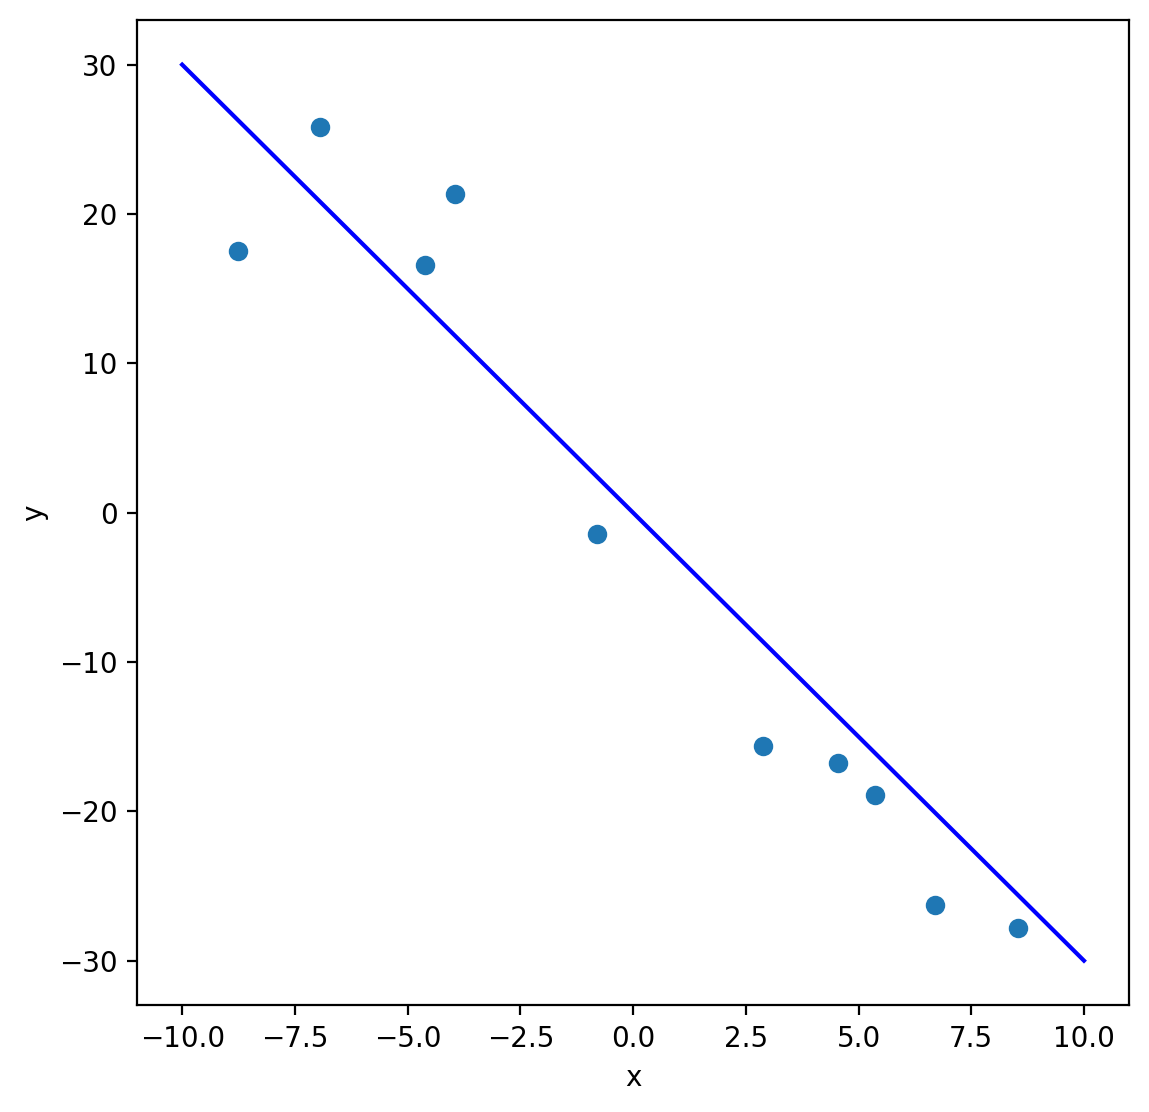

In [23]:
fig = plt.figure(figsize=(6.4, 6.4), dpi=200)
ax = plt.axes()

ax.scatter(x, y)
xs = np.linspace(-10, 10)
ax.plot(xs, theta_true[0] * xs + theta_true[1], color="blue")
ax.set_xlabel("x")
ax.set_ylabel("y")

plt.savefig("example1-data.png")
plt.show()

In [24]:
from scipy.stats import norm

tau1 = 3.0
tau2 = 3.0

def log_prior(theta):
    w = theta[:2]
    log_s = theta[2]

    log_p_w = norm.logpdf(w, 0, tau1).sum()
    log_p_s = norm.logpdf(log_s, 0, tau2)

    return log_p_w + log_p_s

def log_likelihood(theta, x, y):
    w = theta[:2]
    s = np.exp(theta[2])
    
    y_pred = w[0] * x + w[1]
    log_lik = norm.logpdf(y, y_pred, s)

    return log_lik

def log_posterior(theta, x, y):
    return log_likelihood(theta, x, y).sum() + log_prior(theta)  # up to a constant

In [25]:
from scipy.stats import multivariate_normal

thetas, accept_ratio = mh_sample(np.array([0.0, 0.0, 0.0]), 50000,
                                 lambda theta: log_posterior(theta, x, y),
                                 lambda theta_t: theta_t + multivariate_normal.rvs(mean=[0.0, 0.0, 0.0], cov=0.1))

print("Accept ratio =", accept_ratio)

100%|██████████| 50000/50000 [00:26<00:00, 1912.12it/s]

Accept ratio = 0.48322


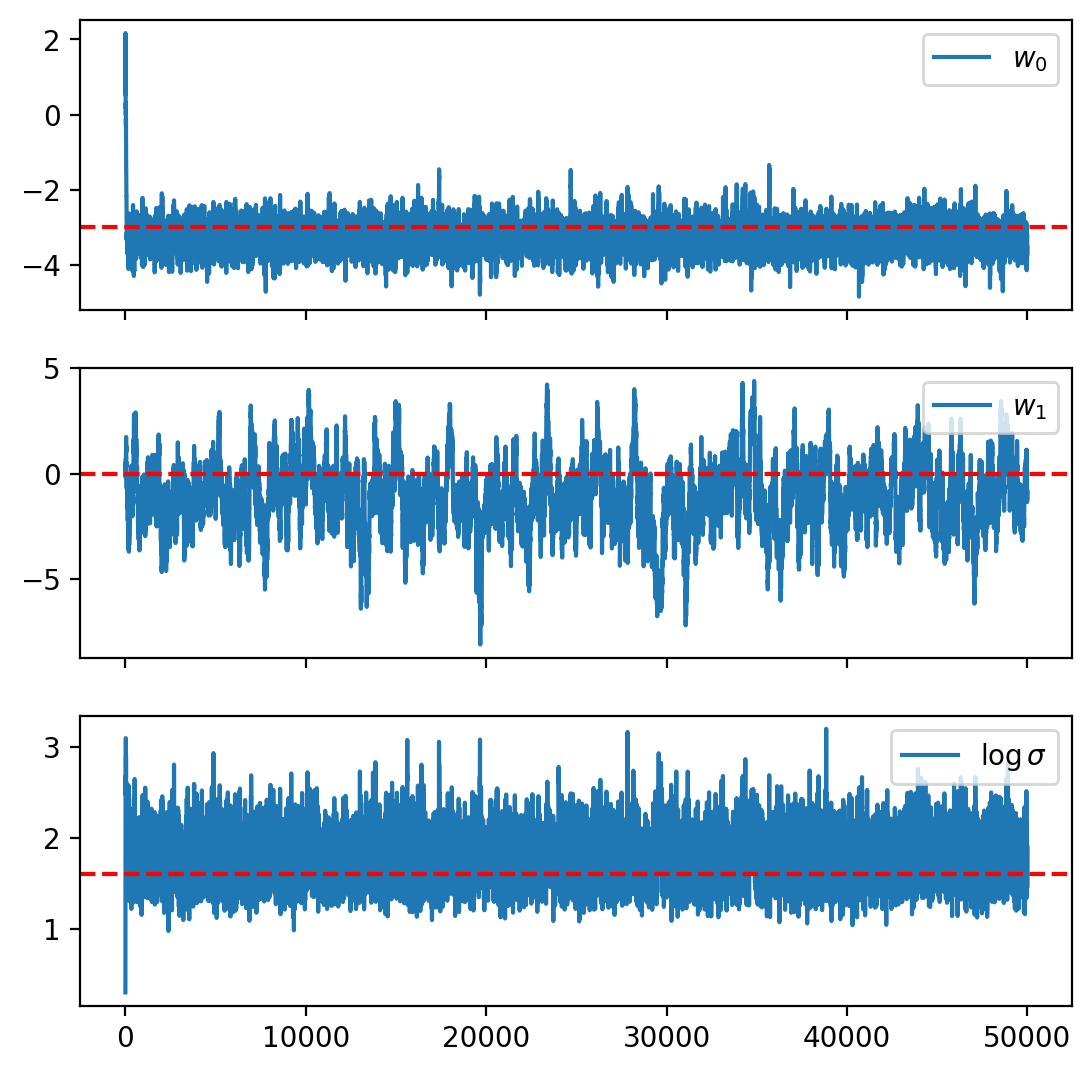

In [26]:
fig, ax = plt.subplots(3, figsize=(6.4, 6.4), dpi=200, sharex=True)

ax[0].plot(thetas[:, 0], label=r"$w_0$")
ax[0].axhline(theta_true[0], color="red", linestyle="--")
ax[0].legend(loc="upper right")
ax[1].plot(thetas[:, 1], label=r"$w_1$")
ax[1].axhline(theta_true[1], color="red", linestyle="--")
ax[1].legend(loc="upper right")
ax[2].plot(thetas[:, 2], label=r"$\log \sigma$")
ax[2].axhline(theta_true[2], color="red", linestyle="--")
ax[2].legend(loc="upper right")

plt.savefig("example1-traces.png")
plt.show()

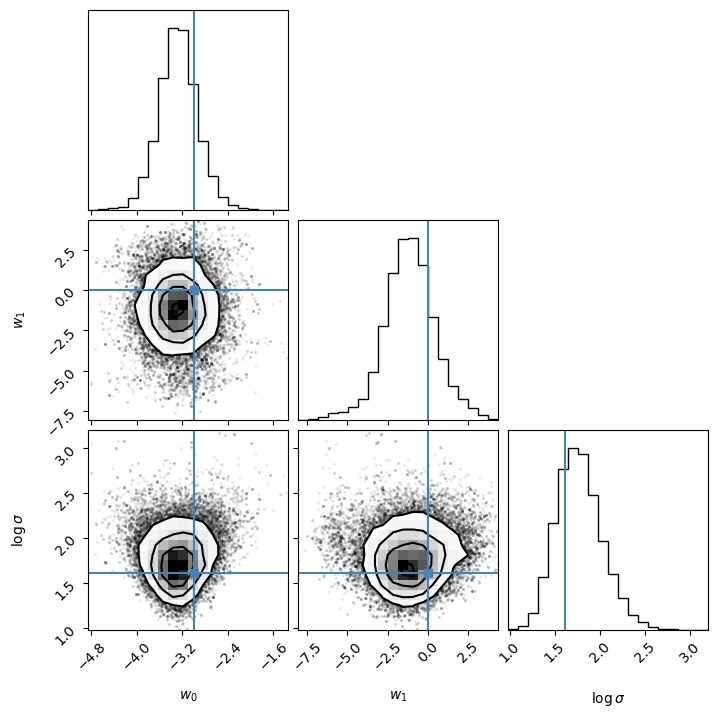

In [27]:
import corner
fig = corner.corner(thetas[1000:], 
                    labels=[r"$w_0$", r"$w_1$", r"$\log \sigma$"], 
                    truths=theta_true, 
                    figsize=(6.4, 6.4), dpi=200)
plt.savefig("example1-corner.png")
plt.show()

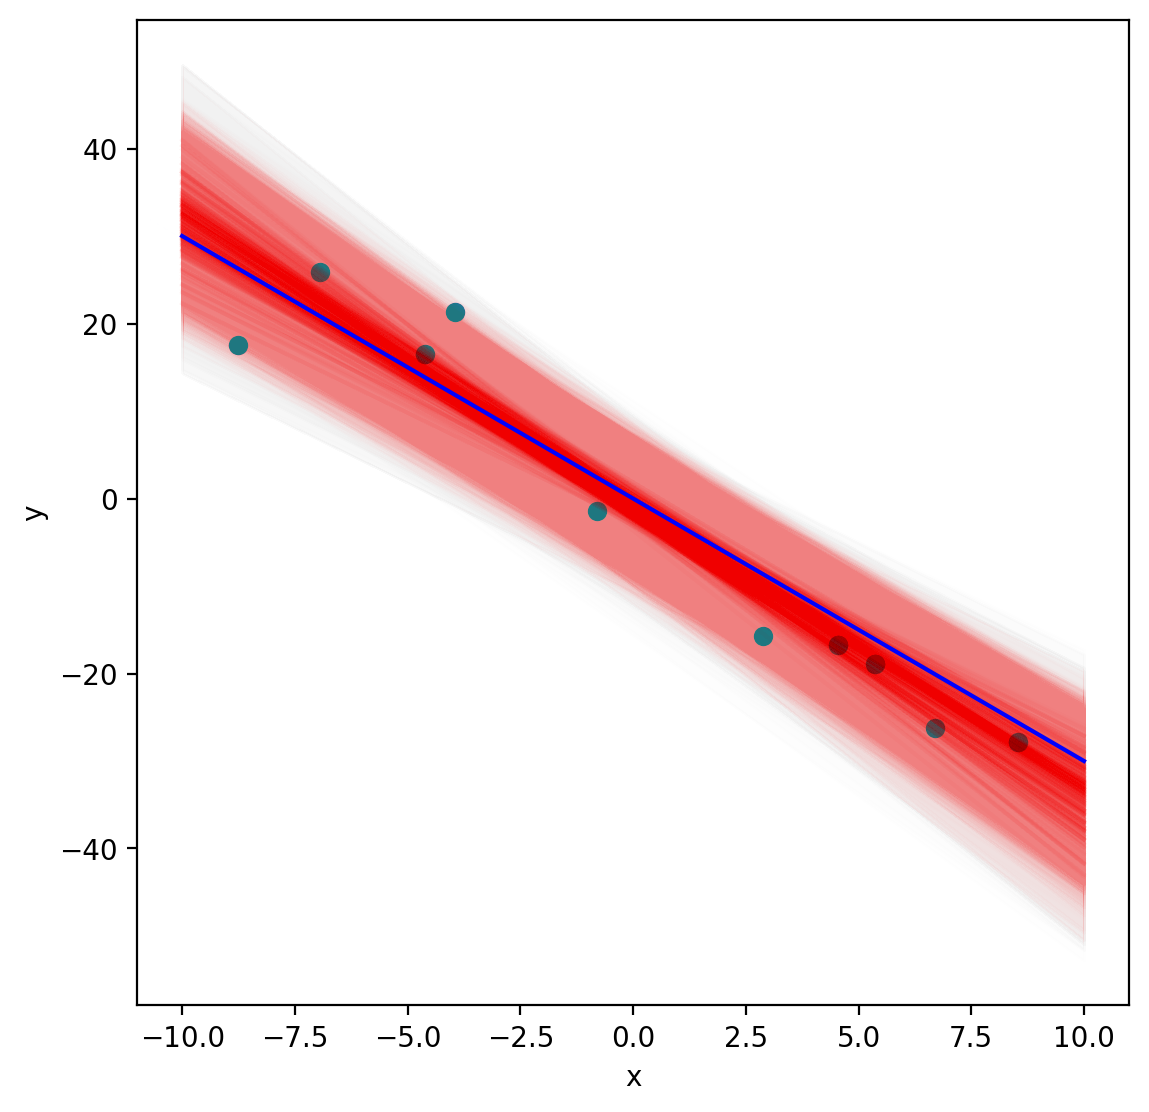

In [28]:
fig = plt.figure(figsize=(6.4, 6.4), dpi=200)
ax = plt.axes()

ax.scatter(x, y)
xs = np.linspace(-10, 10)
warmup = 1000

for i in range(1000):
    ax.fill_between(xs, 
                    thetas[warmup+i, 0] * xs + thetas[warmup+i, 1] - np.exp(thetas[warmup+i, 2]),
                    thetas[warmup+i, 0] * xs + thetas[warmup+i, 1] + np.exp(thetas[warmup+i, 2]),
                    color="lightcoral", alpha=0.005)
    
    ax.plot(xs, thetas[warmup+i, 0] * xs + thetas[warmup+i, 1], color="r", alpha=0.01)

ax.plot(xs, theta_true[0] * xs + theta_true[1], color="blue")
#ax.set(ylim=(-50,50))

ax.set_xlabel("x")
ax.set_ylabel("y")

plt.savefig("example1-pp.png")

plt.show()

# `emcee`

In [29]:
import emcee

pos = np.array([0.0, 0.0, 0.0]) + 0.1 * np.random.randn(10, 3)
nwalkers, ndim = pos.shape

In [30]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x, y))
sampler.run_mcmc(pos, 100000 // nwalkers, progress=True);

100%|██████████| 10000/10000 [00:20<00:00, 482.32it/s]


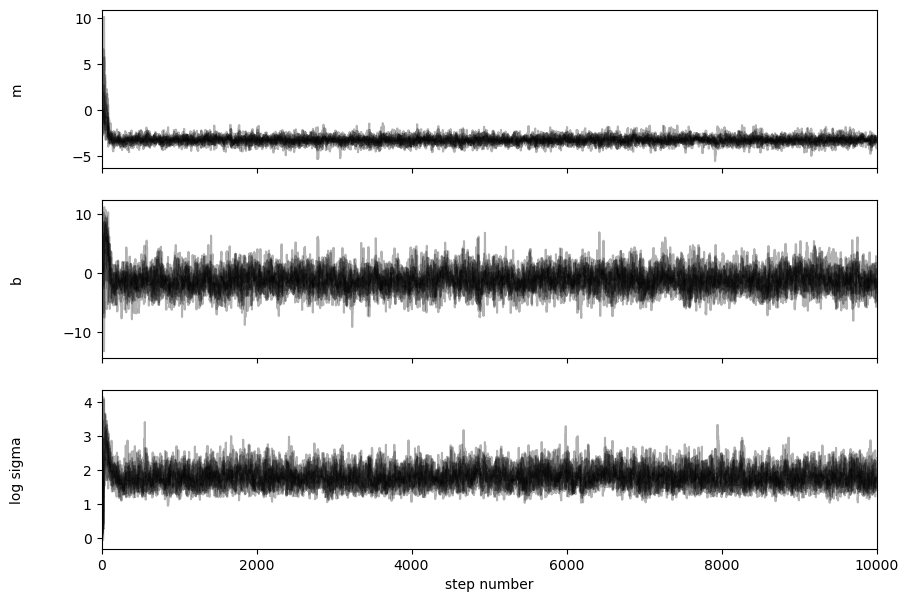

In [31]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log sigma"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.show()

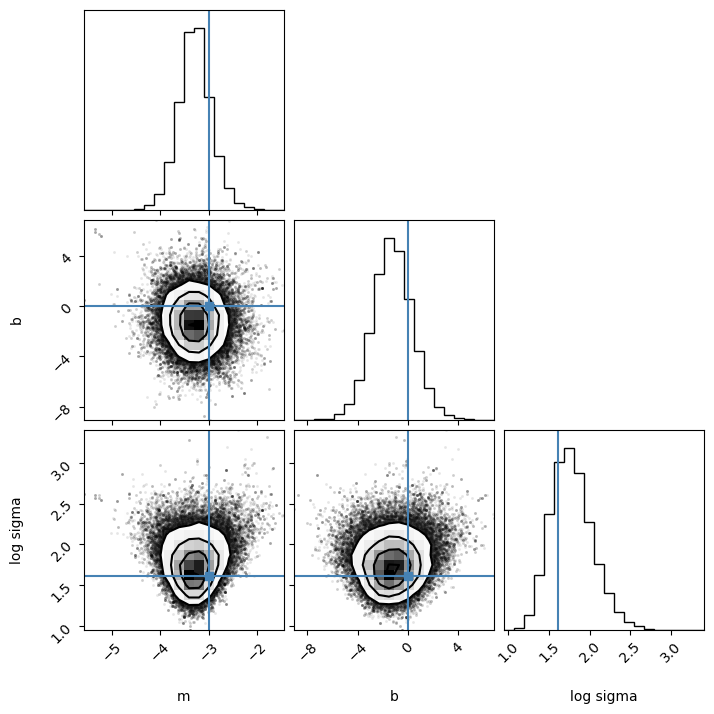

In [32]:
import corner
thetas = sampler.get_chain(flat=True, discard=200)
fig = corner.corner(thetas, labels=labels, truths=theta_true)

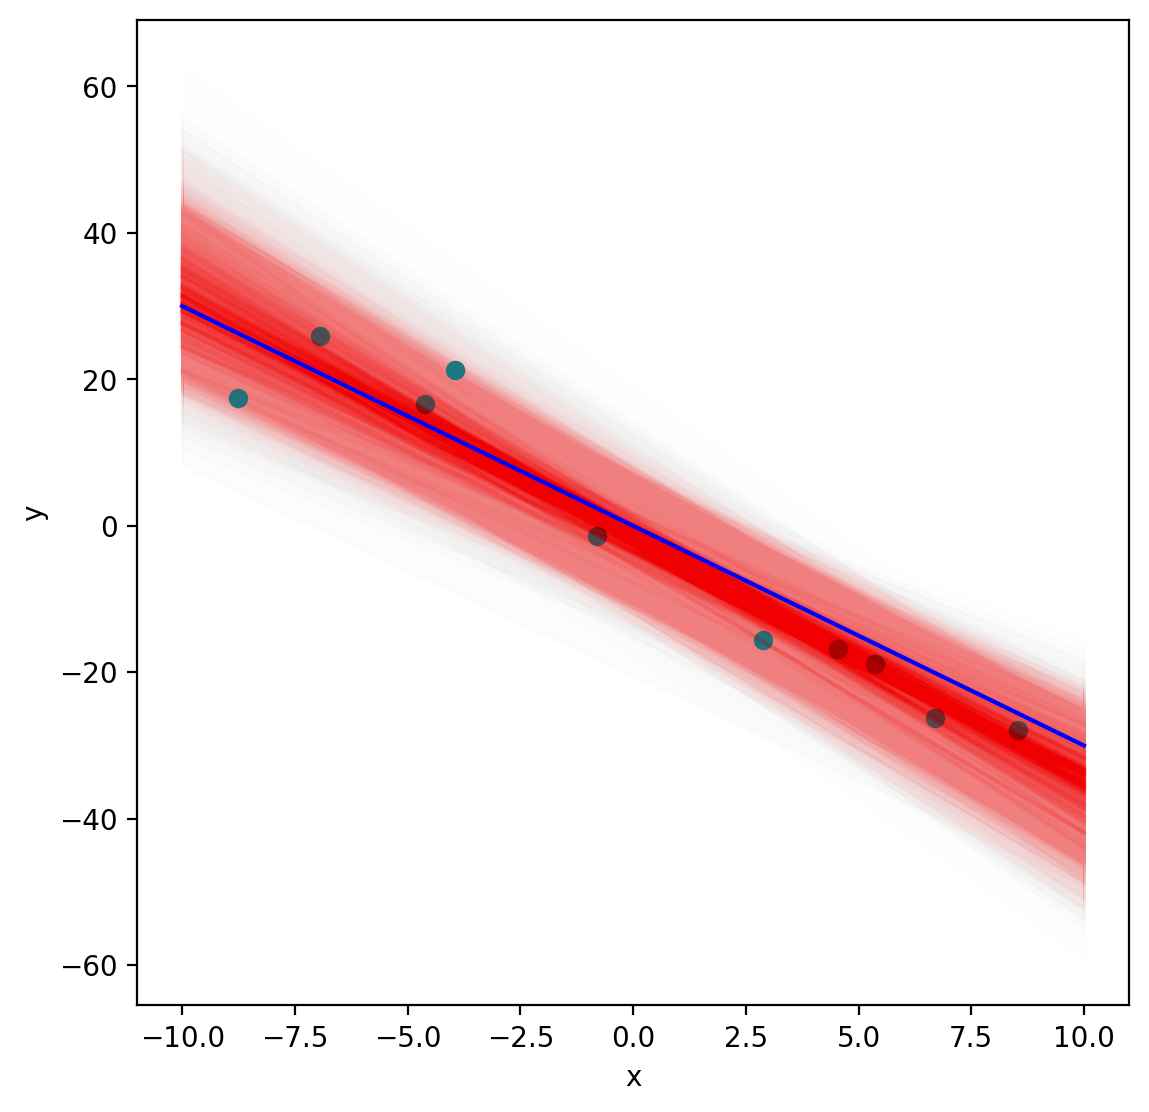

In [33]:
fig = plt.figure(figsize=(6.4, 6.4), dpi=200)
ax = plt.axes()

ax.scatter(x, y)
xs = np.linspace(-10, 10)
warmup = 1000

for i in range(1000):
    ax.fill_between(xs, 
                    thetas[warmup+i, 0] * xs + thetas[warmup+i, 1] - np.exp(thetas[warmup+i, 2]),
                    thetas[warmup+i, 0] * xs + thetas[warmup+i, 1] + np.exp(thetas[warmup+i, 2]),
                    color="lightcoral", alpha=0.005)
    
    ax.plot(xs, thetas[warmup+i, 0] * xs + thetas[warmup+i, 1], color="r", alpha=0.01)

ax.plot(xs, theta_true[0] * xs + theta_true[1], color="blue")
#ax.set(ylim=(-50,50))

ax.set_xlabel("x")
ax.set_ylabel("y")

plt.show()

In [34]:
# Integrated autocorrelation time
tau = sampler.get_autocorr_time()
tau

array([55.26013217, 42.53782061, 40.16683916])

In [35]:
# Effective sample size
samples = sampler.get_chain(flat=True)
n_eff = len(samples) / tau
n_eff

array([1809.62288855, 2350.84916339, 2489.61586446])

In [36]:
# Gelman-Rubin statistic 
def gelman_rubin(chains):
    m, n, d = chains.shape
    chain_means = np.mean(chains, axis=1)
    overall_mean = np.mean(chain_means, axis=0)

    B = n / (m - 1) * np.sum((chain_means - overall_mean) ** 2, axis=0)
    W = 1 / m * np.sum(np.var(chains, axis=1, ddof=1), axis=0)

    var_hat = (n - 1) / n * W + B / n
    R_hat = np.sqrt(var_hat / W)

    return R_hat

chains = sampler.get_chain()
R_hat = gelman_rubin(chains)
R_hat

array([1.23297125, 1.04846491, 1.06751888])